MNIST _ Training

In [1]:
%matplotlib inline
%config InlineBackend.figure_format= 'retina'

import numpy as np
import pandas as pd
import torch
import helper
import matplotlib.pyplot as plt

In [2]:
from torchvision import datasets,transforms

In [3]:
batch_size=64

In [17]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset=datasets.MNIST('../data/MNIST_data/',download=False,transform=transform,train=True)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testset=datasets.MNIST('../data/MNIST_data/',download=False,transform=transform,train=False)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)


In [5]:
dataIter = iter(trainloader)
images, labels = dataIter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


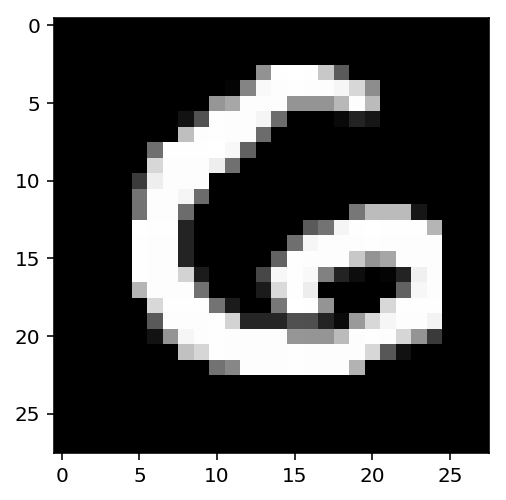

In [6]:
plt.imshow(images[1].numpy().squeeze(),cmap="Greys_r");

Network Architecture :  
Input : 784 (28x28)  
n_hidden units : 256  
n_hidden layers :1  
n_output : 10  

In [7]:
def activation(x):
    return 1/(1+torch.exp(-x))

def softmax(x):
    den_sum=torch.sum(torch.exp(x),dim=1).view(-1,1)
    soft=torch.exp(x)/den_sum;
    return soft

In [8]:
input_x = images.view(images.shape[0],-1)
input_size=input_x.shape[1];
n_hidden=256
n_output=10

W1=torch.randn((input_size,n_hidden));
W2=torch.randn((n_hidden,n_output));

B1=torch.randn((1,n_hidden));
B2=torch.randn((1,n_output));

a1=activation(torch.mm(input_x,W1)+B1)
out=torch.mm(a1,W2)+B2

In [9]:
prob=softmax(out)

In [10]:
prob.shape

torch.Size([64, 10])

In [9]:
from torch import nn
import torch.nn.functional as F

In [12]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        n_hidden=[128,64]
        n_output=10
        self.hidden1=nn.Linear(784,n_hidden[0])
        self.hidden2=nn.Linear(n_hidden[0],n_hidden[1])
        self.output=nn.Linear(n_hidden[1],n_output)
        
#         self.sigmoid = nn.Sigmoid()
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        x=F.relu(self.hidden1(x))
        x=F.relu(self.hidden2(x))
#         x=self.hidden(x);
#         x=self.sigmoid(x);
#         x=self.output(x);
#         x=self.softmax(x);
        x=F.softmax(self.output(x),dim=1)
    
        return x

In [13]:
model = Network()
model

Network(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

Using Sequential pytorch API

In [14]:
n_hidden=[128,64]
n_output=10
model = nn.Sequential(nn.Linear(784,n_hidden[0]),
                     nn.ReLU(),
                     nn.Linear(n_hidden[0],n_hidden[1]),
                     nn.ReLU(),
                     nn.Linear(n_hidden[1],n_output),
                     nn.LogSoftmax(dim=1))
            

In [15]:
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [16]:
##Loss Definition
criterion=nn.NLLLoss()

images,labels=next(iter(trainloader))
images=images.view(images.shape[0],-1)

## For crossEntrophy logits are the scores we need to pass to our crossentrophy function
## to decrease error
# But for NNLoss we can pass log_probs directly to NNLoss so Logits = log_probs
print(images.shape)

logits = model(images)
loss = criterion(logits,labels)

print("Loss is ",loss)

torch.Size([64, 784])
Loss is  tensor(2.3037)


Doing Autograd to calculate derivative of x

In [17]:
x=torch.rand(1,requires_grad=True)

In [18]:
x

tensor([ 0.8721])

In [19]:
y=x**3

See whether grad is enabled or not

In [20]:
print(y.grad_fn)

In [21]:
print(x.grad)

None


In [22]:
y.backward()
print(x.grad)

tensor([ 2.2818])


we should get 3x^2 .. Let's see

In [23]:
3*x**2

tensor([ 2.2818])

Yep!

In [24]:
print("Before backward pass : model weight at layer 0 is",model[0].weight.grad)

Before backward pass : model weight at layer 0 is None


In [25]:
loss.backward() # Enabled backward pass

In [26]:
print("After backward pass : model weight at layer 0 is",model[0].weight.grad)

After backward pass : model weight at layer 0 is tensor(1.00000e-02 *
       [[-0.2047, -0.2047, -0.2047,  ..., -0.2047, -0.2047, -0.2047],
        [ 0.3868,  0.3868,  0.3868,  ...,  0.3868,  0.3868,  0.3868],
        [-0.1654, -0.1654, -0.1654,  ..., -0.1654, -0.1654, -0.1654],
        ...,
        [ 0.1426,  0.1426,  0.1426,  ...,  0.1426,  0.1426,  0.1426],
        [-0.0244, -0.0244, -0.0244,  ..., -0.0244, -0.0244, -0.0244],
        [ 0.1422,  0.1422,  0.1422,  ...,  0.1422,  0.1422,  0.1422]])


## Training the newtork

In [27]:
from torch import optim

In [28]:
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [29]:
print("Initial weights ",model[0].weight)
optimizer.zero_grad() # This is done to avoid gradients accumulation
output=model(images)
loss=criterion(output,labels)
loss.backward()
print("Gradient ",model[0].weight.grad)

optimizer.step()

print("Updated Weights ",model[0].weight)

Initial weights  Parameter containing:
tensor([[ 1.6896e-02,  2.5839e-02, -3.2175e-02,  ...,  9.8781e-03,
          9.0211e-03, -1.8437e-02],
        [-3.3466e-02,  3.3557e-02, -1.2504e-02,  ..., -2.2777e-03,
         -3.2859e-02, -9.4156e-03],
        [-9.5676e-03,  2.6340e-02,  1.7379e-02,  ...,  1.6697e-02,
          1.2404e-02, -8.2505e-03],
        ...,
        [ 2.9888e-03, -1.1079e-02, -1.0062e-02,  ...,  1.9263e-02,
         -3.4641e-02,  2.0131e-02],
        [-1.3735e-03, -1.2904e-03, -2.3114e-02,  ...,  2.4467e-03,
          3.3908e-02, -2.7143e-04],
        [ 2.2984e-02, -5.7740e-03, -2.3975e-02,  ...,  1.1721e-02,
          2.1640e-02,  1.2228e-03]])
Gradient  tensor(1.00000e-02 *
       [[-0.2047, -0.2047, -0.2047,  ..., -0.2047, -0.2047, -0.2047],
        [ 0.3868,  0.3868,  0.3868,  ...,  0.3868,  0.3868,  0.3868],
        [-0.1654, -0.1654, -0.1654,  ..., -0.1654, -0.1654, -0.1654],
        ...,
        [ 0.1426,  0.1426,  0.1426,  ...,  0.1426,  0.1426,  0.1426],
     

## FInal Model

In [30]:
Model = nn.Sequential(nn.Linear(images.shape[1],n_hidden[0]),
                     nn.ReLU(),
                     nn.Linear(n_hidden[0],n_hidden[1]),
                     nn.ReLU(),
                     nn.Linear(n_hidden[1],n_output),
                     nn.LogSoftmax(dim=1))
criterion=nn.NLLLoss()
optimizer=optim.SGD(Model.parameters(),lr=0.003)

In [31]:
print(Model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [32]:
epochs=5;
for e in range(epochs):
    running_loss=0;
    for images,labels in trainloader:
        images=images.view(images.shape[0],-1)
        output=Model(images)
        optimizer.zero_grad()
        loss=criterion(output,labels)
        loss.backward();
        optimizer.step()
        
        running_loss=running_loss+loss.item();
    else:
        print("Training loss: ",running_loss/len(trainloader))
        

Training loss:  1.8497461094530916
Training loss:  0.8122107085388607
Training loss:  0.5258027431108295
Training loss:  0.4332217181891775
Training loss:  0.3883526737470108


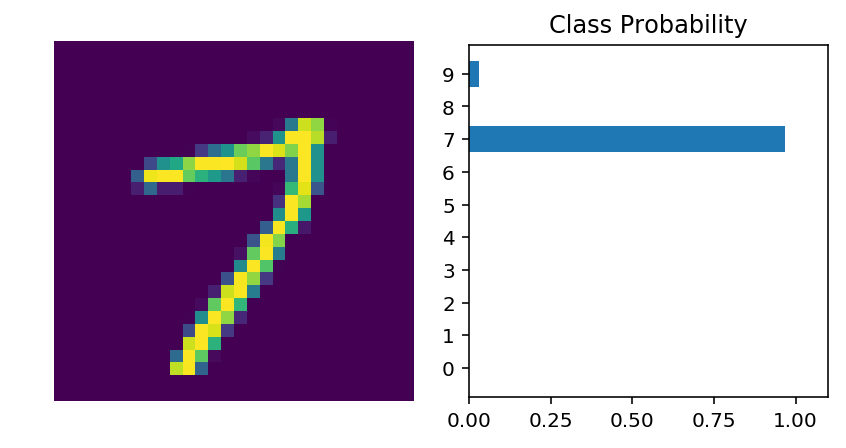

In [35]:
images,labels=next(iter(trainloader))
img=images[0].view(1,784)
with torch.no_grad():
    logits=Model(img)

ps=F.softmax(logits,dim=1)

helper.view_classify(img.view(1,28,28),ps)

In [7]:
import fc_loader

In [20]:
Model=fc_loader.Network(784,10,[512,512],dropout_p=0.2)

In [21]:
criterion=nn.NLLLoss()

In [22]:
optimizer=torch.optim.Adam(Model.parameters())

In [23]:
train_loss,test_loss,accuracy=fc_loader.train(Model,trainloader,testloader,criterion,optimizer,5)

Epoch: 1/5..  Training Loss: 0.329..  Test Loss: 0.173..  Test Accuracy: 0.947
Epoch: 2/5..  Training Loss: 0.178..  Test Loss: 0.130..  Test Accuracy: 0.958
Epoch: 3/5..  Training Loss: 0.142..  Test Loss: 0.101..  Test Accuracy: 0.968
Epoch: 4/5..  Training Loss: 0.127..  Test Loss: 0.092..  Test Accuracy: 0.972
Epoch: 5/5..  Training Loss: 0.113..  Test Loss: 0.093..  Test Accuracy: 0.971


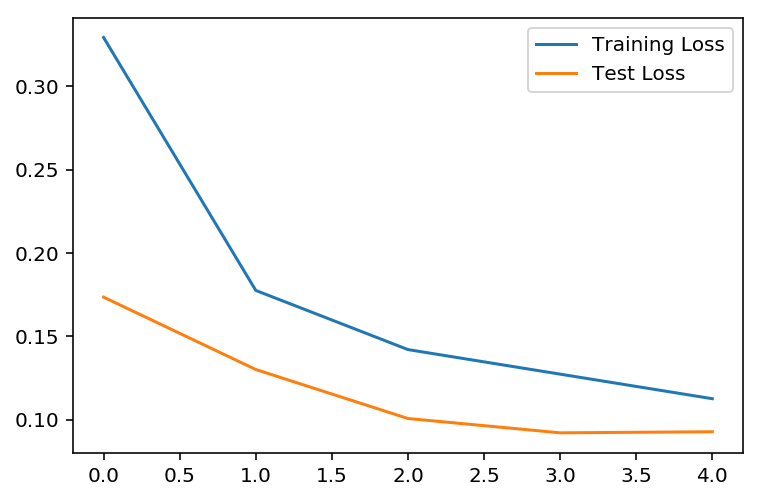

In [24]:
plt.plot(train_loss,label='Training Loss');
plt.plot(test_loss,label='Test Loss');
plt.legend();